In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('data_OCR_2109.txt', sep = '\t')

In [9]:
# On va chercher à supprimer les images de moins de 20 ko, ou de dimension inférieure à 400 pixels, 
# qui seront de trop mauvaise qualité pour être correctement analysées.
for i in range(df.shape[0]):
    if (df['width'][i] <= 400) | (df['height'][i] <= 400) | (df['size'][i] <= 20000):
        df = df.drop(i, axis = 0)
df = df.reset_index().drop('index', axis = 1)

In [11]:
df.head(10)
df.shape

(1324, 7)

## Visualisation de l'OCR-isation des documents

On utilise des Bounding Box pour visualiser, sur quelques exemples de documents, ce que PyTesseract peut détecter.
On utilise deux fonctions de PyTesseract : la fonction image_to_boxes (fonction TesseractITB) et la fonction image_to_data (fonction TesseractITD).

In [4]:
# pip install opencv-python

In [12]:
import cv2

In [13]:
import pytesseract
pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
def TesseractITB(image):
    img = cv2.imread(image)
    h, w, _ = img.shape
    boxes = pytesseract.image_to_boxes(img)
    for b in boxes.splitlines():
        b = b.split(' ')
        img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
    plt.figure(figsize = (10,10))
    plt.imshow(img);
    plt.axis('off')
    

In [14]:
from scipy.ndimage import rotate
from pytesseract import Output
def TesseractITD(img):
    img = cv2.imread(img)
    img2 = img.copy()
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if float(d['conf'][i]) > 40:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img2 = cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(img2[...,::-1])
    plt.axis('off')

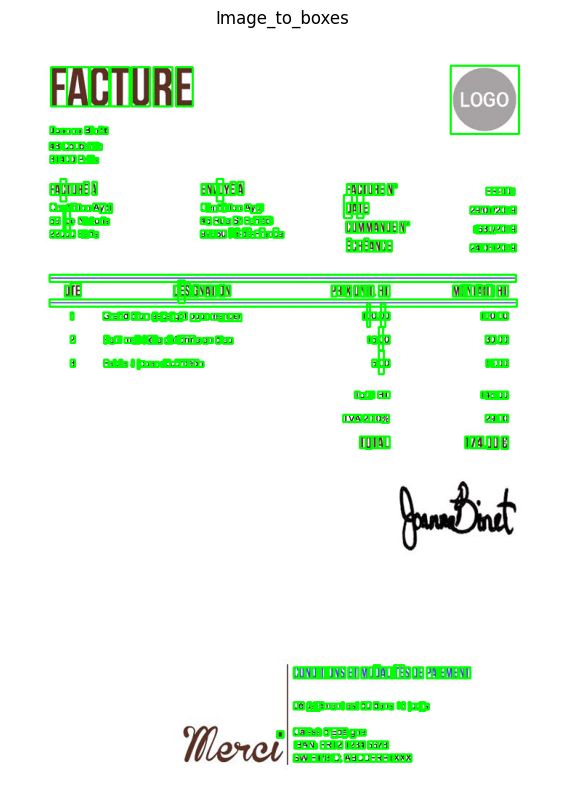

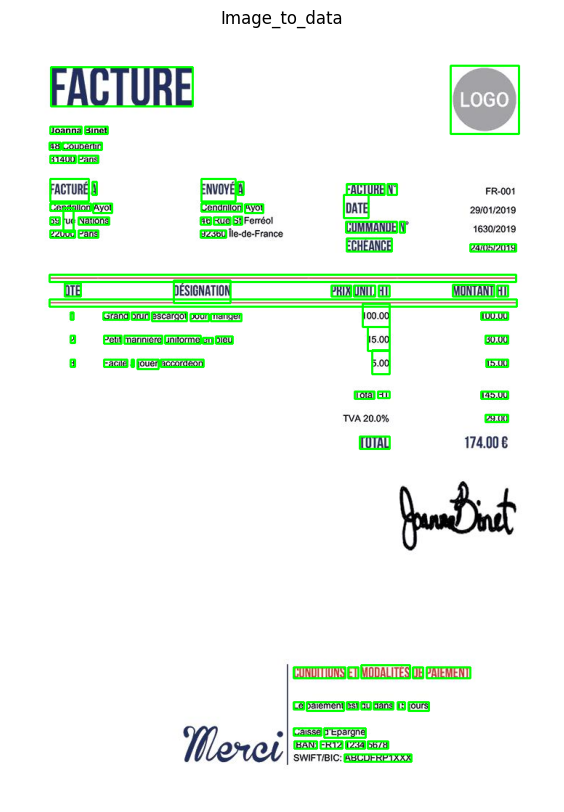

In [15]:
TesseractITB('img_0000000.jpg')
plt.title('Image_to_boxes');
plt.figure(figsize = (10,10))
TesseractITD('img_0000000.jpg')
plt.title('Image_to_data');

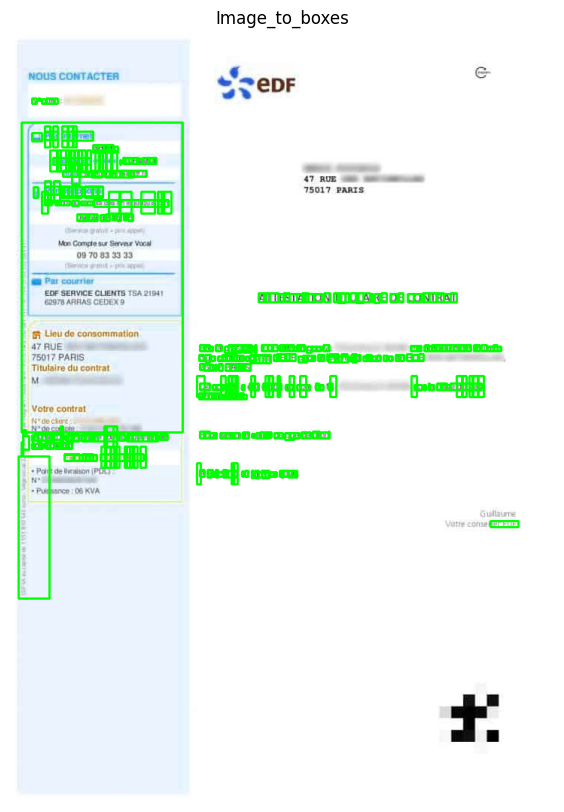

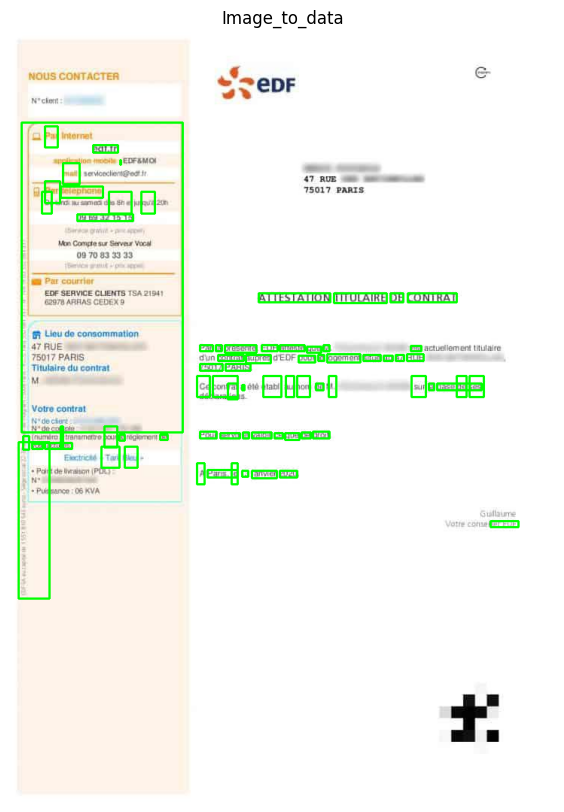

In [16]:
TesseractITB('img_0000211.jpg')
plt.title('Image_to_boxes');
plt.figure(figsize = (10,10))
TesseractITD('img_0000211.jpg')
plt.title('Image_to_data');

## Cherchons à redresser des images déformées, par exemple sur les cartes d'identité.

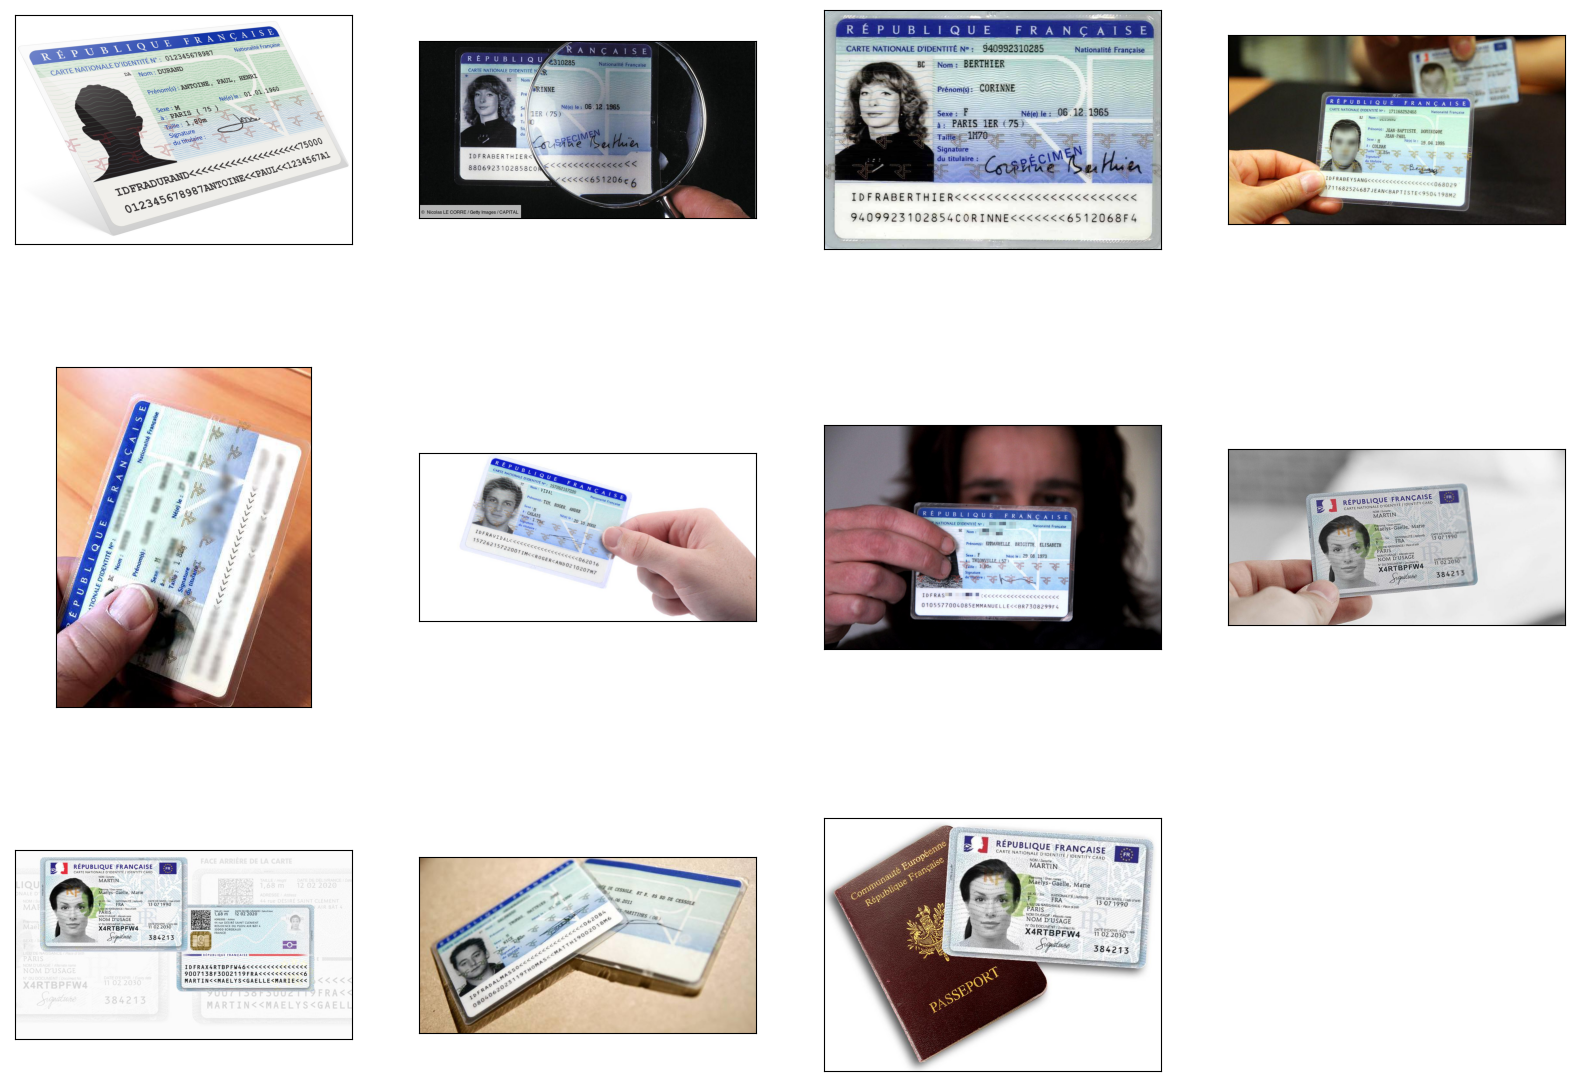

In [20]:
from glob import glob

list_template = sorted(glob("template/*"))

imgs_template = [cv2.imread(p, cv2.IMREAD_COLOR) for p in list_template]

plt.figure(figsize=(20,15))
for i in range(len(imgs_template)):
    plt.subplot(3,4,i+1)
    plt.imshow(imgs_template[i][...,::-1])
    plt.xticks([])
    plt.yticks([])

plt.show()

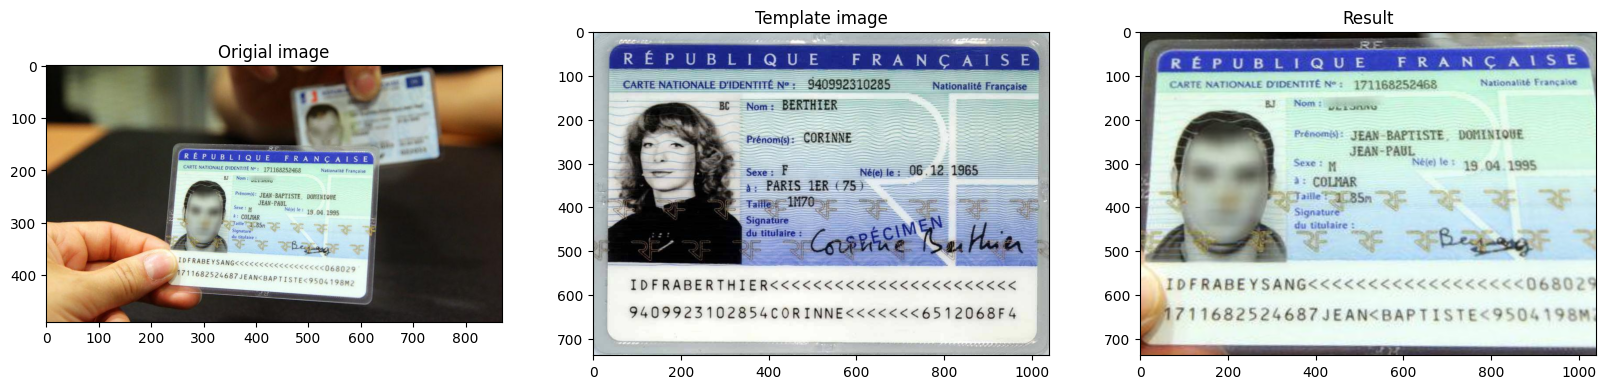

In [27]:
MAX_FEATURES = 10000
GOOD_MATCH_PERCENT = 0.15

def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]


    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))
    
    
    # Compute a euclidean distance between projection keypoints and keypoints matching
    points1_vect = np.ones([points1.shape[0], 3])
    points1_vect[...,:2] = points1
    projection =  points1_vect @ h.T
    projection = projection[...,:2]/projection[...,2:]
    distance =  np.sqrt(np.square(projection-points2).sum(-1)).mean()

    return im1Reg, h, distance



im = cv2.imread("template/2.jpg", cv2.IMREAD_COLOR)

imReference = imgs_template[2]

imReg, h, distance = alignImages(im, imReference)



plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(im[...,::-1])
plt.title('Origial image')
plt.subplot(132)
plt.imshow(imReference[...,::-1])
plt.title('Template image')
plt.subplot(133)
plt.imshow(imReg[...,::-1])
plt.title('Result')

plt.show()

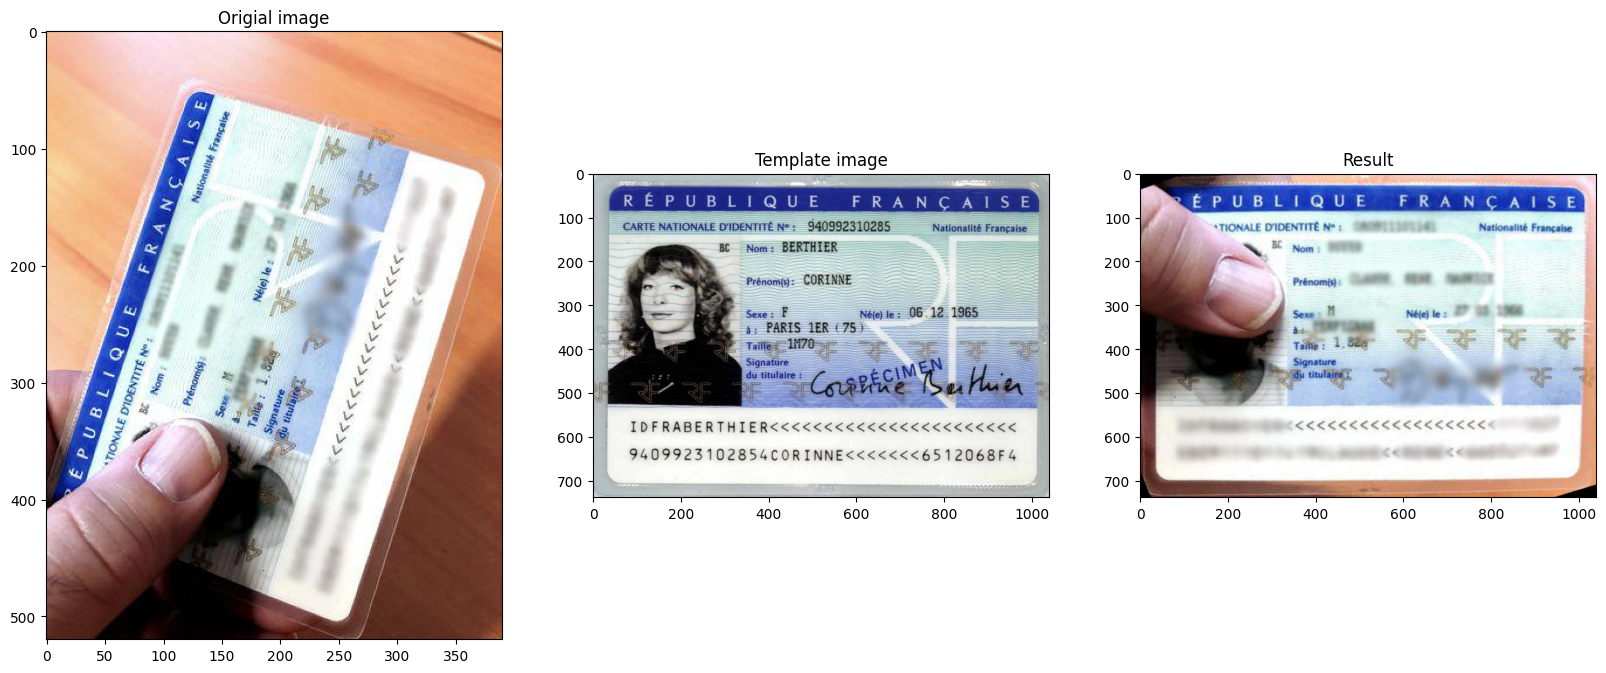

In [28]:
MAX_FEATURES = 10000
GOOD_MATCH_PERCENT = 0.15

im = cv2.imread("template/3.jpg", cv2.IMREAD_COLOR)
imReference = imgs_template[2]
imReg, h, distance = alignImages(im, imReference)

plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(im[...,::-1])
plt.title('Origial image')
plt.subplot(132)
plt.imshow(imReference[...,::-1])
plt.title('Template image')
plt.subplot(133)
plt.imshow(imReg[...,::-1])
plt.title('Result')

plt.show()

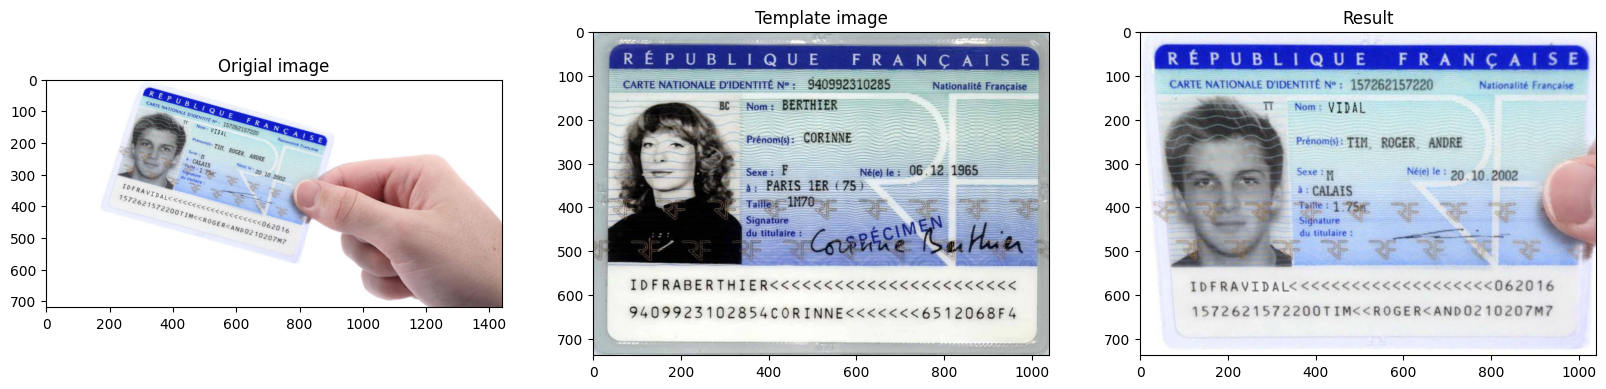

In [29]:
MAX_FEATURES = 10000
GOOD_MATCH_PERCENT = 0.15

im = cv2.imread("template/4.jpg", cv2.IMREAD_COLOR)
imReference = imgs_template[2]
imReg, h, distance = alignImages(im, imReference)

plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(im[...,::-1])
plt.title('Origial image')
plt.subplot(132)
plt.imshow(imReference[...,::-1])
plt.title('Template image')
plt.subplot(133)
plt.imshow(imReg[...,::-1])
plt.title('Result')

plt.show()

On observe de bons résultats avec la plupart des images. Pour l'image numéro 1, à cause de sa grande différence d'échelle par rapport au template (l'image originale étant en 4000x3000 pixels), il faut passer par une étape de redimensionnement supplémentaire.


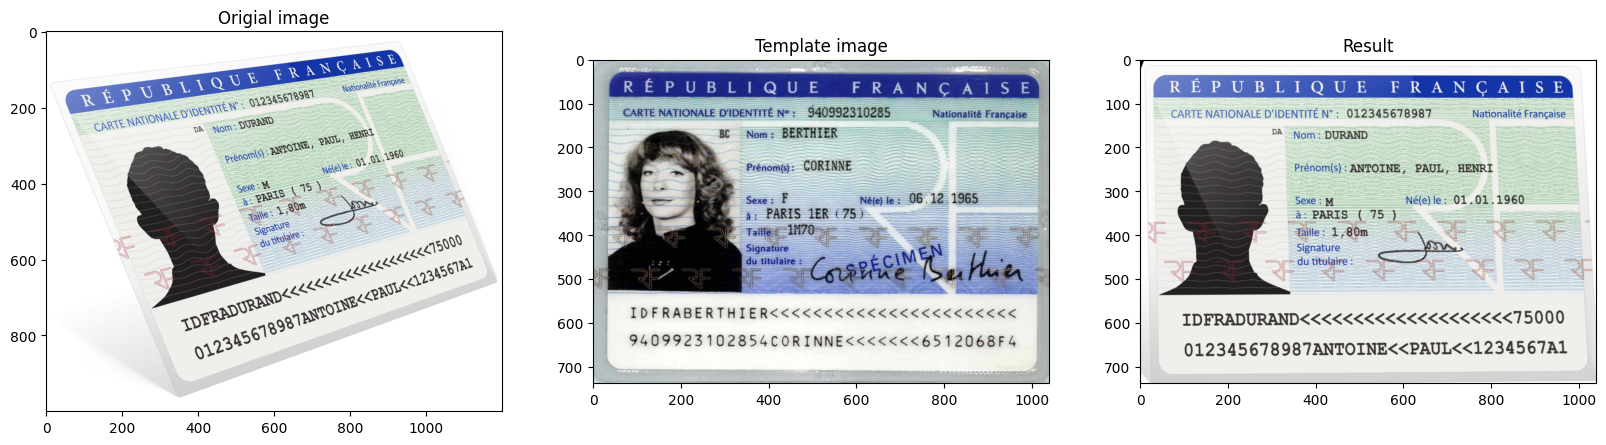

In [30]:
MAX_FEATURES = 25000
GOOD_MATCH_PERCENT = 0.15

im = cv2.imread("template/1.jpg", cv2.IMREAD_COLOR)
im = cv2.resize(im, (1200,1000))
imReference = imgs_template[2]
imReg, h, distance = alignImages(im, imReference)

plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(im[...,::-1])
plt.title('Origial image')
plt.subplot(132)
plt.imshow(imReference[...,::-1])
plt.title('Template image')
plt.subplot(133)
plt.imshow(imReg[...,::-1])
plt.title('Result')

plt.show()

#### Cependant, cela ne fonctionne pas à tous les coups. Sur l'image ci-dessous, impossible de trouver de bons paramètres pour centrer l'image sur la carte. C'est possiblement dû au format de carte qui est légèrement différent.

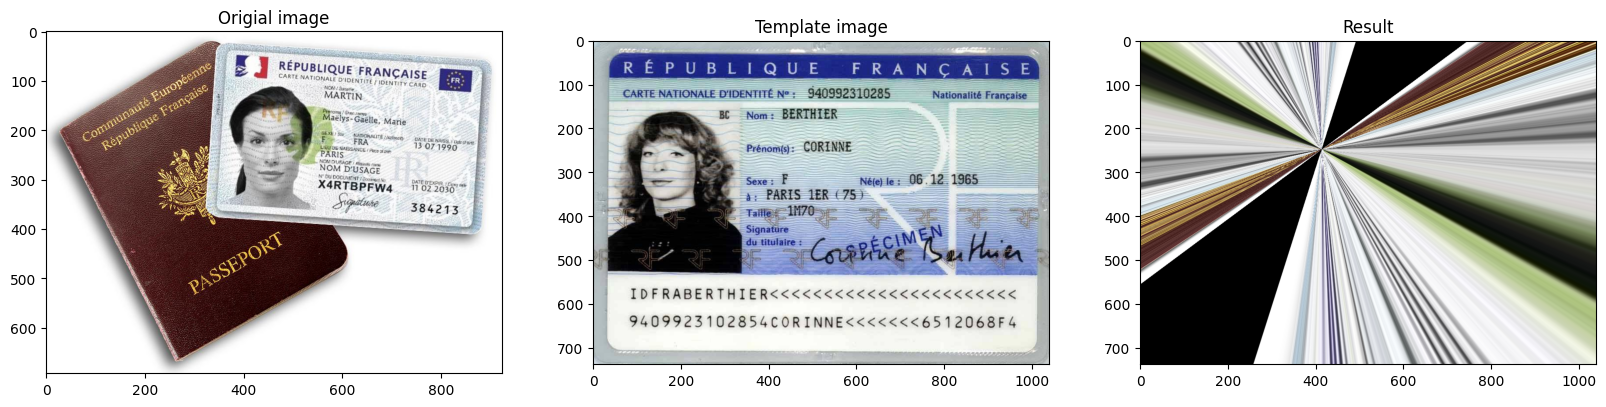

In [31]:
MAX_FEATURES = 15000
GOOD_MATCH_PERCENT = 0.15

im = cv2.imread("template/9.jpg", cv2.IMREAD_COLOR)
imReference = imgs_template[2]
imReg, h, distance = alignImages(im, imReference)

plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(im[...,::-1])
plt.title('Origial image')
plt.subplot(132)
plt.imshow(imReference[...,::-1])
plt.title('Template image')
plt.subplot(133)
plt.imshow(imReg[...,::-1])
plt.title('Result')

plt.show()

# Visualisation des caractéristiques du dataset.
## Dimensions et poids des images.

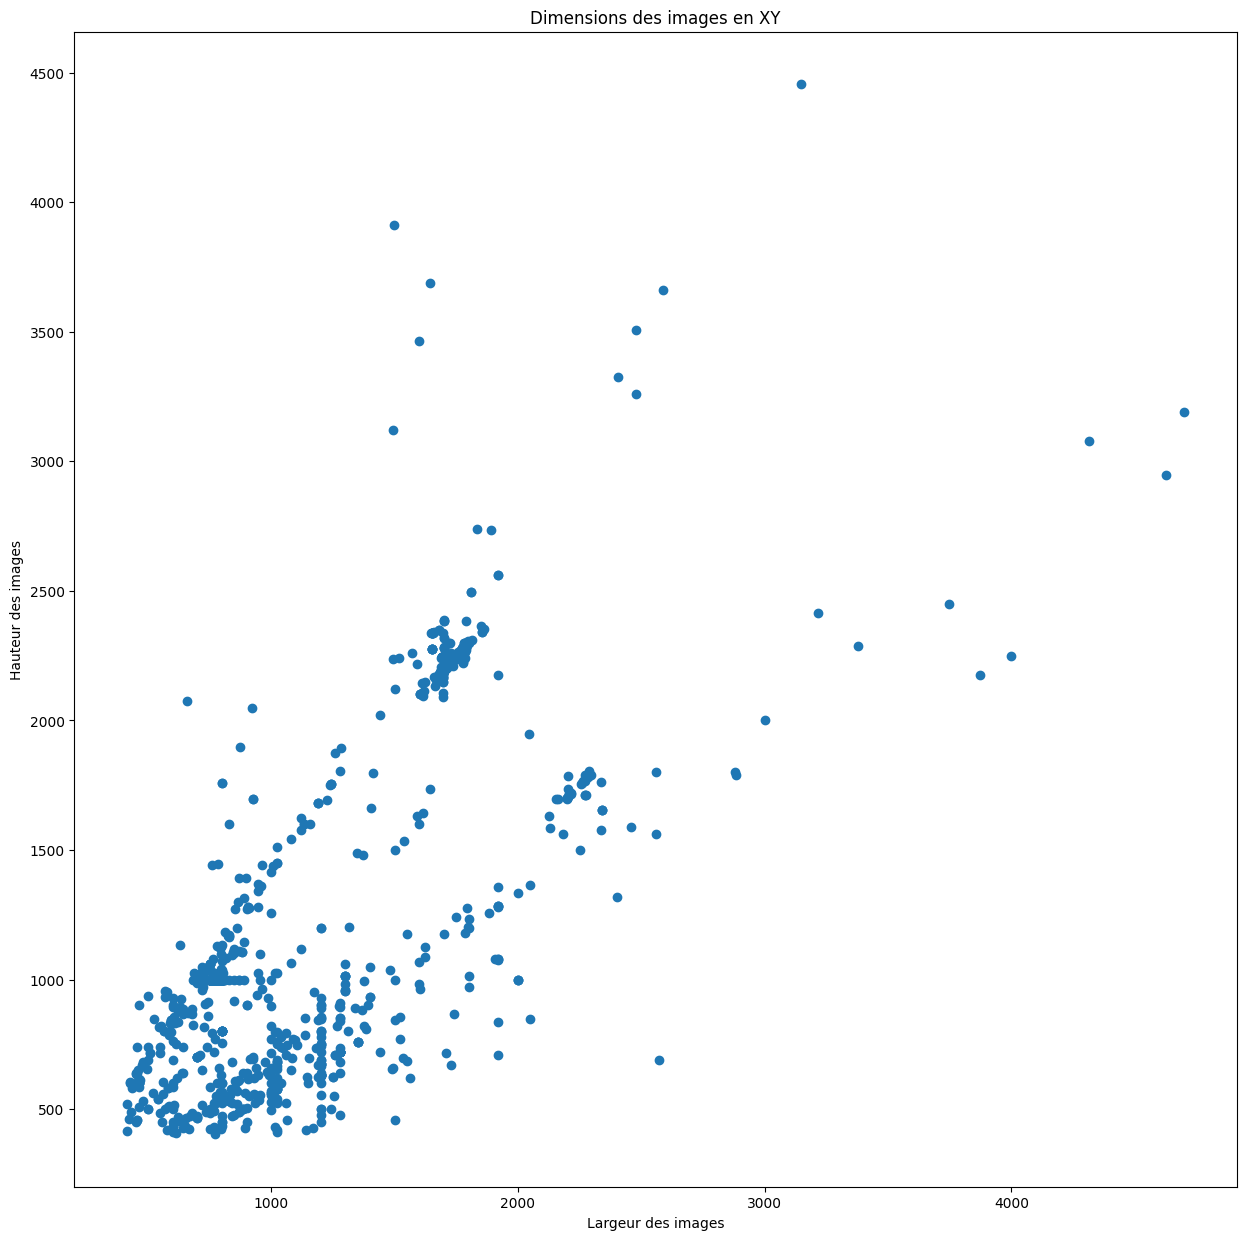

In [32]:
%matplotlib inline
plt.figure(figsize = (15,15))
plt.scatter(df['width'], df['height'])
plt.xlabel('Largeur des images')
plt.ylabel('Hauteur des images')
plt.title('Dimensions des images en XY')
plt.show()

On observe que les images ont des tailles assez diverses : certaines sont inférieures à 500x500 pixels, d'autres supérieures à 3000x3000. Pas de ratio longueur/largeur particulier à signaler, on a au maximum du 3:1.
 

Essayons maintenant de regarder ces dimensions en fonction du type de document déclaré.

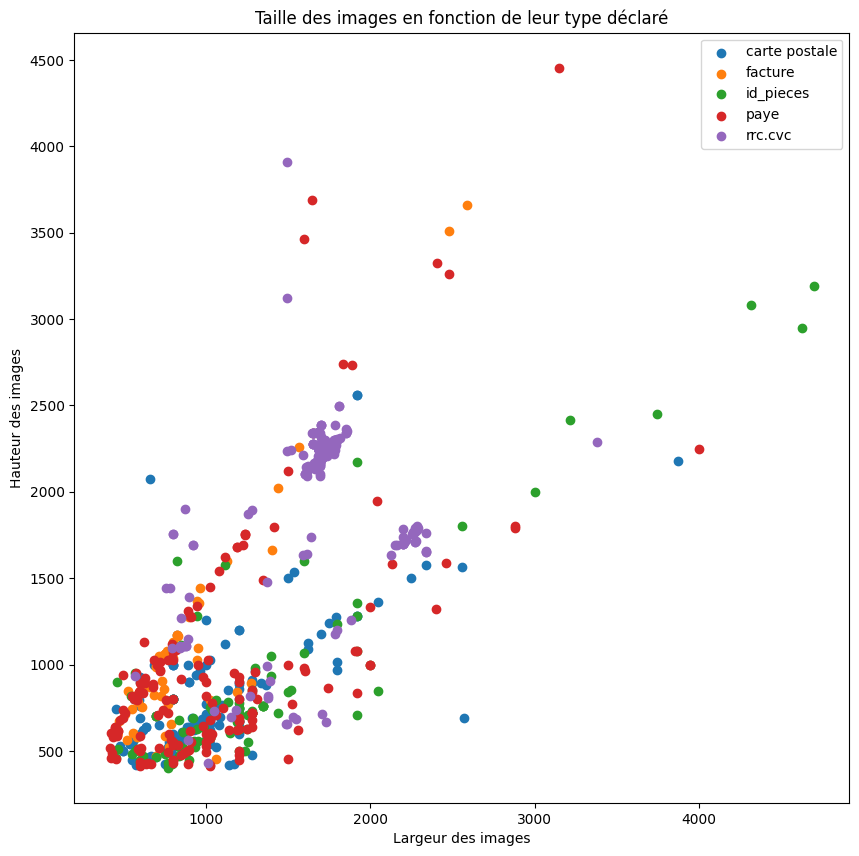

In [33]:
df_1 = df[(df['type'] == 'id_pieces') |(df['type'] == 'carte postale') | (df['type'] == 'rrc.cvc') | (df['type'] == 'facture') | (df['type'] == 'paye')]
df_2 = df[(df['type'] == 'justif_domicile') | (df['type'] == 'passeport')]
df_3 = df[(df['type'] == 'invoice') | (df['type'] == 'specification') | (df['type'] == 'advertisement') | (df['type'] == 'budget') | (df['type'] == 'letter') | (df['type'] == 'email') | (df['type'] == 'form') | (df['type'] == 'memo') | (df['type'] == 'news_article') | (df['type'] == 'handwritten') |(df['type'] == 'presentation') | (df['type'] == 'questionnaire') | (df['type'] == 'resume') | (df['type'] == 'file_folder') | (df['type'] == 'scientific_publication') | (df['type'] == 'scientific_report') | (df['type'] == 'publication')]
groups1 = df_1.groupby('type')
groups2 = df_2.groupby('type')
groups3 = df_3.groupby('type')

plt.figure(figsize = (10,10))
for name, group in groups1:
    plt.scatter(group.width, group.height, label=name)
plt.legend()
plt.xlabel('Largeur des images')
plt.ylabel('Hauteur des images')
plt.title('Taille des images en fonction de leur type déclaré')
plt.show()


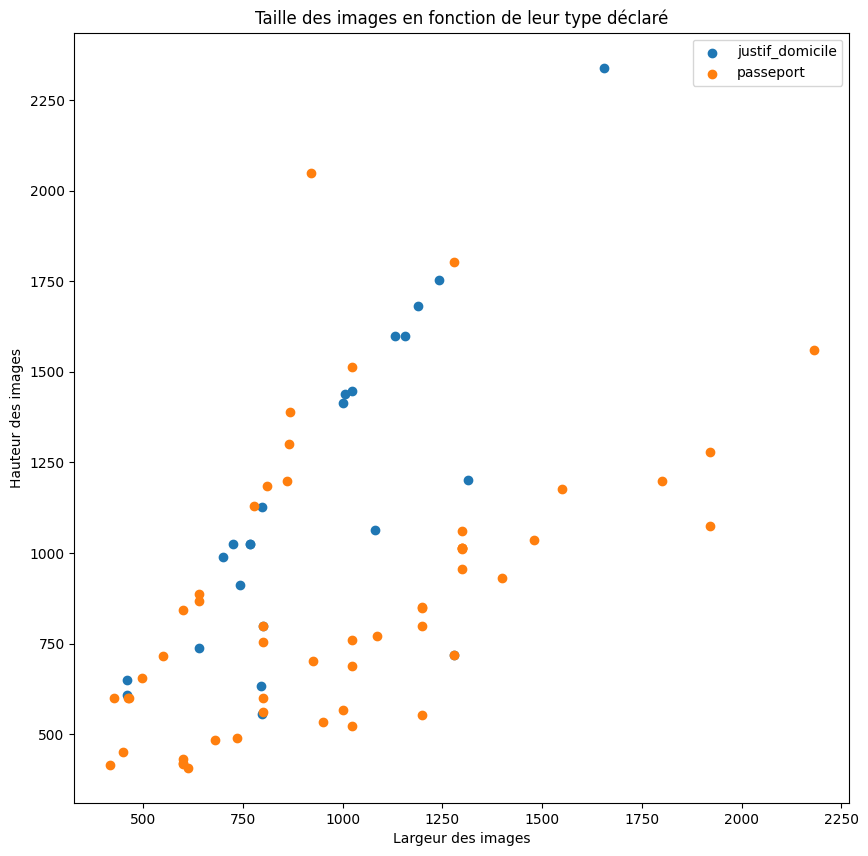

In [34]:
plt.figure(figsize = (10,10))
for name, group in groups2:
    plt.scatter(group.width, group.height, label=name)
plt.legend()
plt.xlabel('Largeur des images')
plt.ylabel('Hauteur des images')
plt.title('Taille des images en fonction de leur type déclaré')
plt.show()


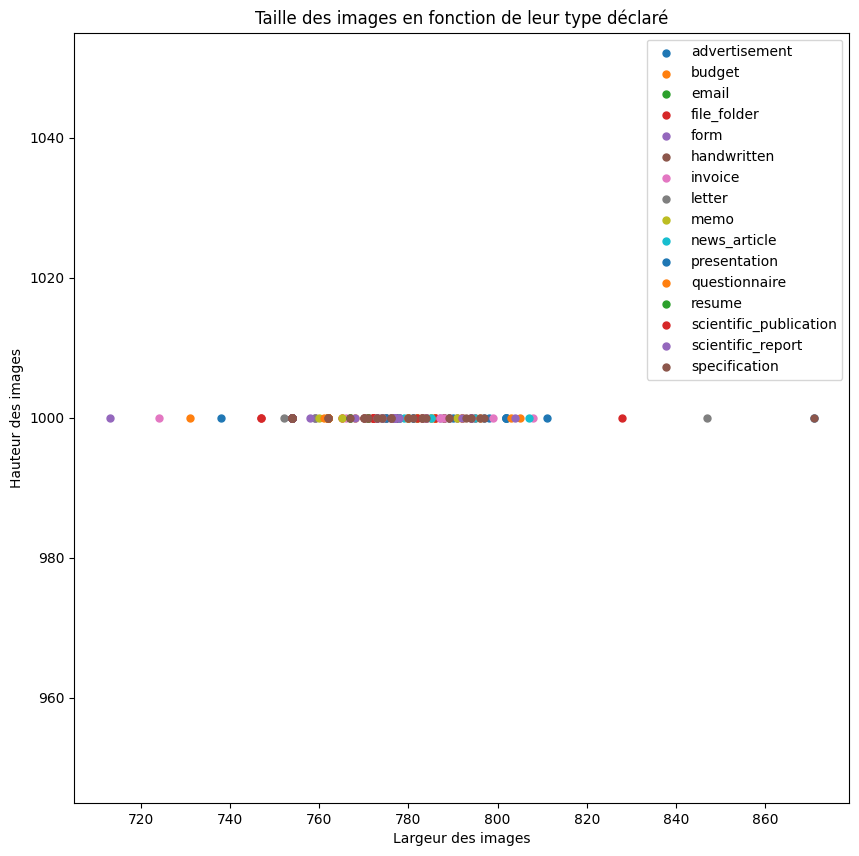

In [35]:
plt.figure(figsize = (10,10))
for name, group in groups3:
    plt.scatter(group.width, group.height, label=name, s = 25)
plt.legend()
plt.xlabel('Largeur des images')
plt.ylabel('Hauteur des images')
plt.title('Taille des images en fonction de leur type déclaré')
plt.show()

On note que 16 catégories sur 23 ont des images faisant quasiment la même taille. Il pourra être intéressant de redimensionner les autres images à cette taille-là pour éviter que le modèle ne tire de conclusions erronées sur cette donnée.

On cherche maintenant à visualiser la taille en octet des documents.

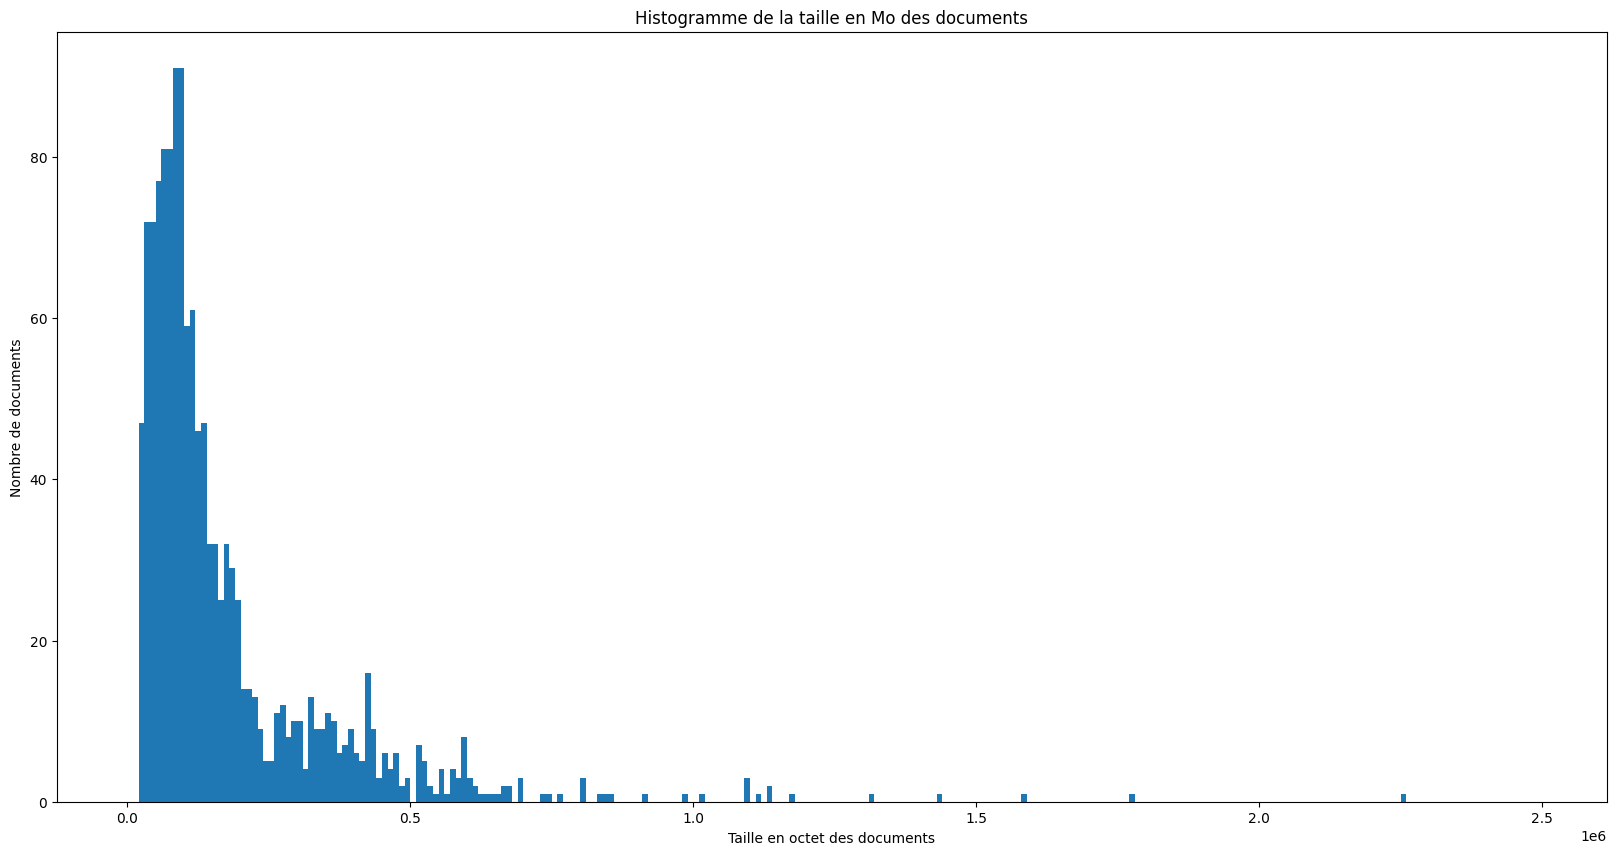

In [36]:
plt.figure(figsize = (20,10))
plt.hist(df['size'], bins = np.arange(0,2500000,10000))
plt.xlabel('Taille en octet des documents')
plt.ylabel('Nombre de documents')
plt.title('Histogramme de la taille en Mo des documents');

On voit qu'une immense majorité des documents ont une taille inférieure à 500 ko (voire à 200ko), mais certaines images sont particulièrement lourdes (comparativement au reste du dataset, du moins), pesant plusieurs Mo.

Evaluons maintenant, grâce à un diagramme "boites à moustache", la répartition de ces tailles en fonction du type de document.

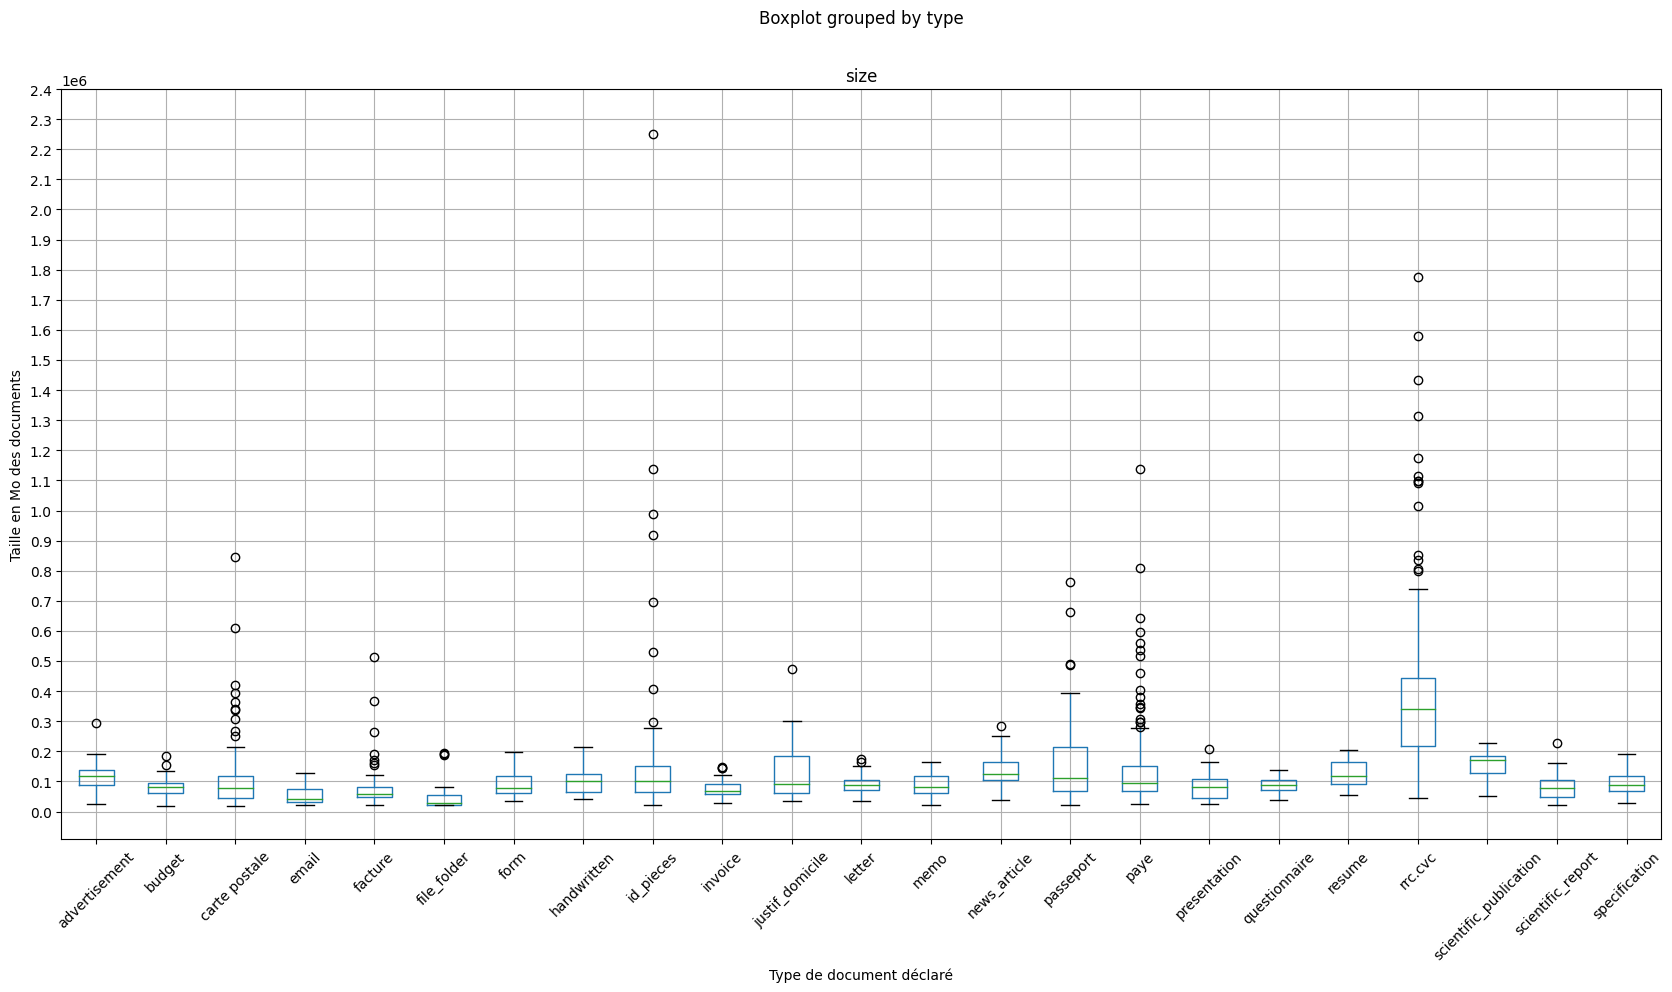

In [37]:
df.boxplot(column = 'size', by='type', figsize = (20,10))
plt.xlabel('Type de document déclaré')
plt.ylabel('Taille en Mo des documents')
plt.xticks(rotation = 45)
plt.yticks(np.arange(0,2500000,100000))
plt.show();

On voit que plusieurs catégories (advertisement, form, handwritten, letter, questionnaire...) ont une taille très règlementée et souvent assez faible (< 200ko). En revanche, les pièces d'identités, fiches de paye, et surtout la catégorie rrc.cvc ont des tailles particulièrement variables.

On a déjà regardé précédemment la distribution des différents types grâce à un value_counts(), mais pour une représentation plus visuelle on peut également utiliser un pie chart :

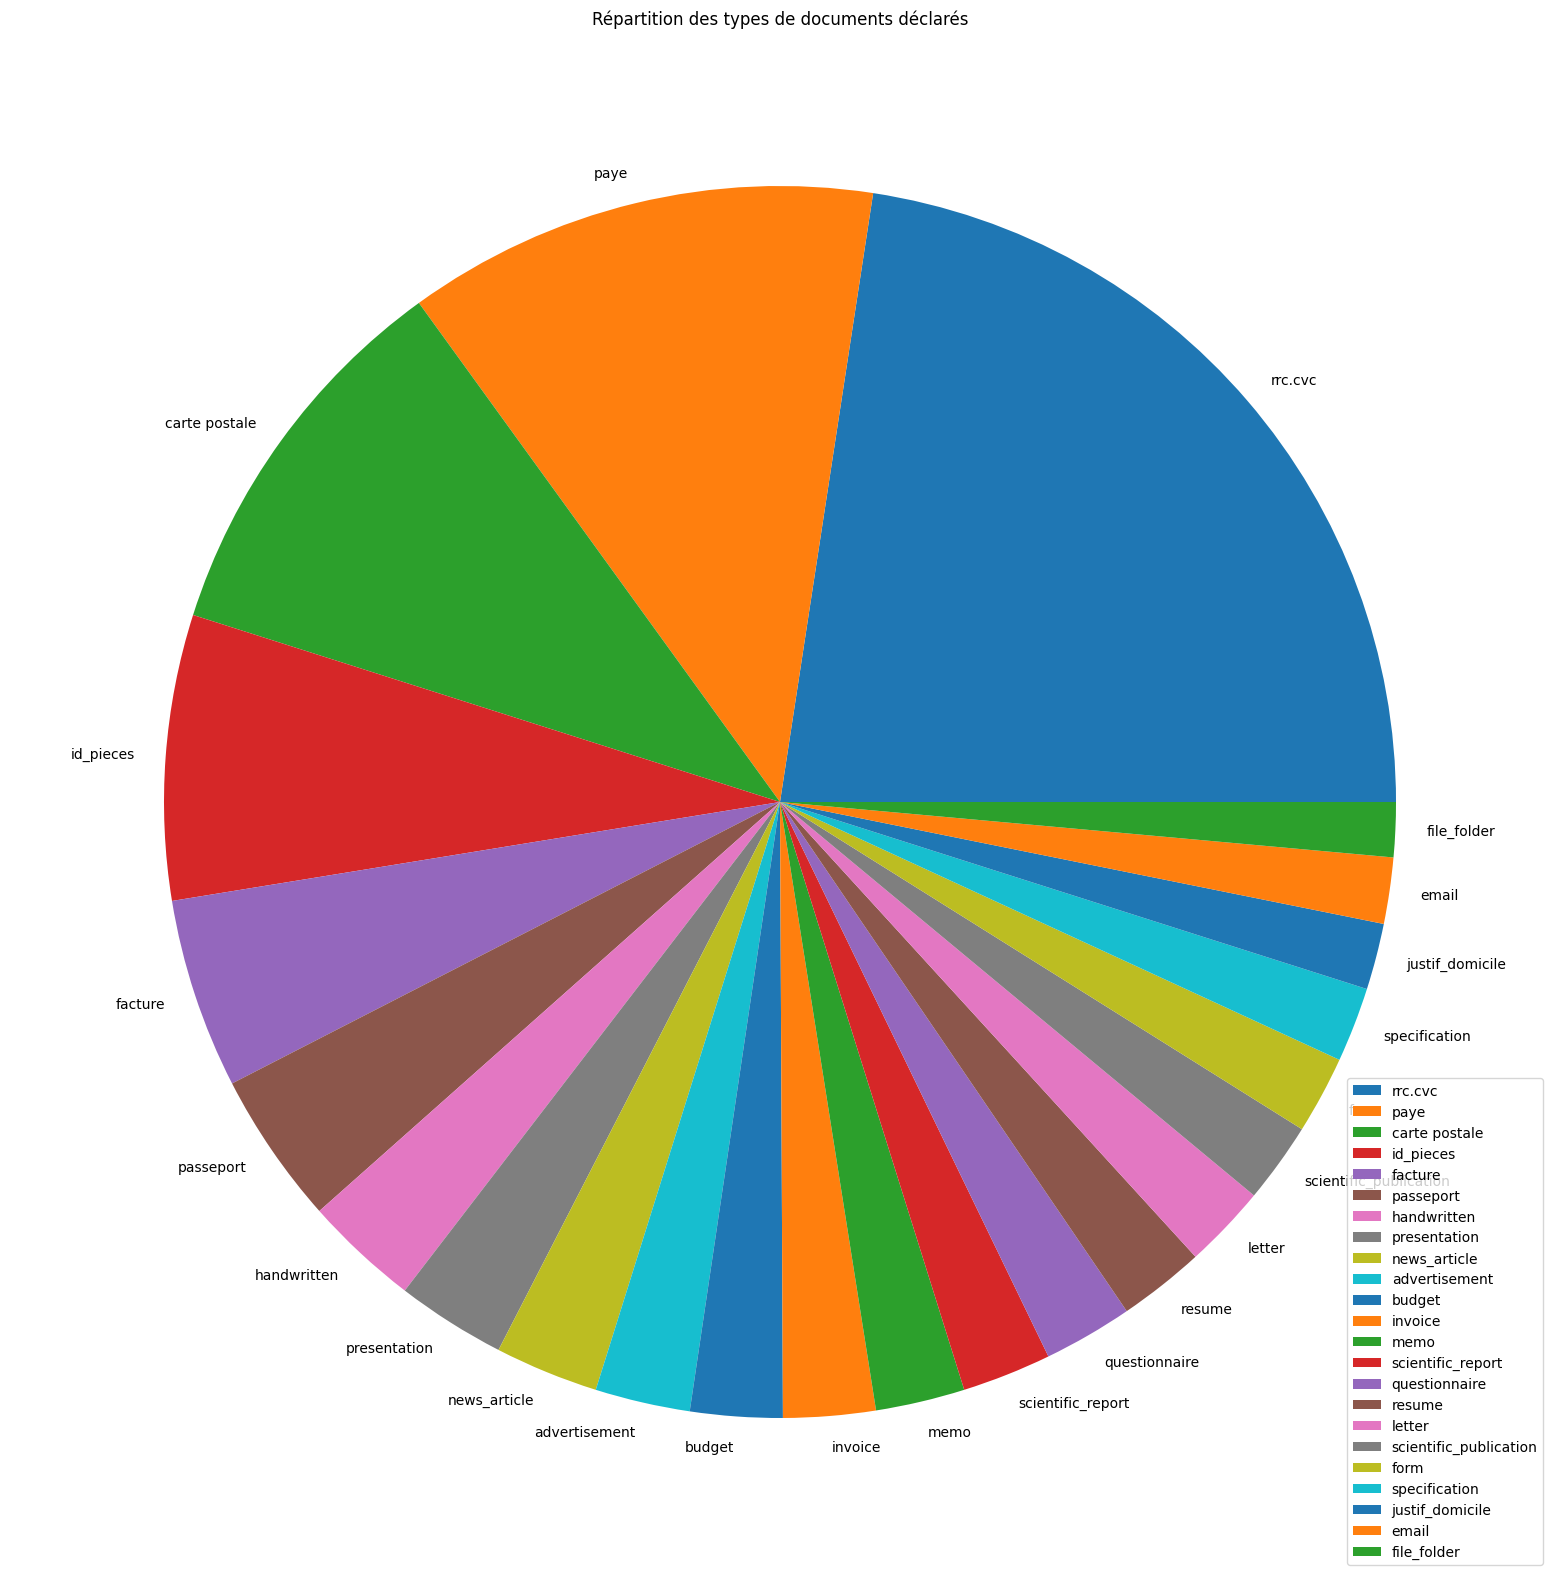

In [38]:
types = list(df.type.value_counts().index)
quantites = list(df.type.value_counts().values)

plt.figure(figsize = (20,20))
plt.pie(quantites, labels = types, labeldistance = 1.05)
plt.title('Répartition des types de documents déclarés')
plt.legend()
plt.show();